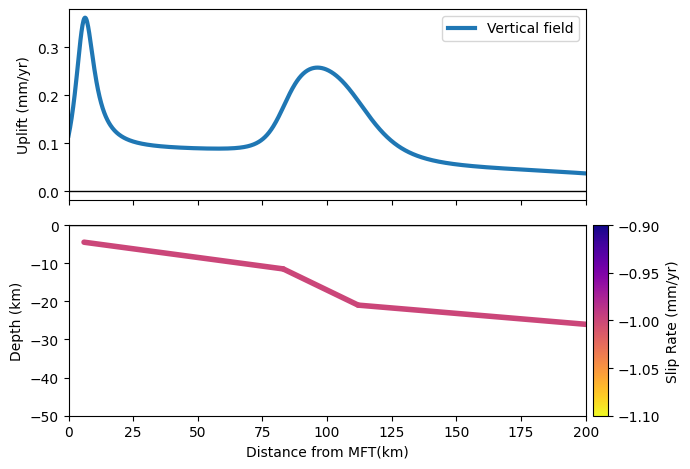

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

x_min, x_max = 0.0, 200.0
y_top, y_bot = 0.0, -50.0
dx_nodes, dy_nodes = 1.0, 1.0

x_nodes = np.arange(x_min, x_max + 0.1, dx_nodes)
y_nodes = np.arange(y_top, y_bot - 0.1, -dy_nodes)

fault_dist = np.array([6, 83, 112, 156+166])
fault_depth = np.array([-4.5, -11.5, -21, -25-8])

slip_values = [-1,-1,-1]

true_faults_geom = []
for i in range(len(fault_dist) - 1):
    seg = {
        'start': (fault_dist[i], fault_depth[i]),
        'end':   (fault_dist[i+1], fault_depth[i+1]),
        'slip':  slip_values[i]
    }
    true_faults_geom.append(seg)

segment_lengths = []
cumulative_lengths = [0.0]
for f in true_faults_geom:
    (x1, z1), (x2, z2) = f['start'], f['end']
    L = np.hypot(x2 - x1, z2 - z1)
    segment_lengths.append(L)
    cumulative_lengths.append(cumulative_lengths[-1] + L)
total_fault_length = cumulative_lengths[-1]

x_obs = np.linspace(x_min, x_max, 1001)

def calculate_uplift_from_slip(x_obs, slip, delta, d_start, x_start, sign_factor):
    if d_start == 0:
        arcterm = np.arctan2(sign_factor * (x_obs - x_start), 1e-12)
        uplift = -(slip / np.pi) * (np.sin(delta) * arcterm)
    else:
        zeta = (sign_factor * (x_obs - x_start)) / d_start
        uplift = -(slip / np.pi) * (np.sin(delta) * np.arctan(zeta) +
                                    (np.cos(delta) + zeta * np.sin(delta)) / (1.0 + zeta**2))
    return uplift

uplift_total = np.zeros_like(x_obs)

for f in true_faults_geom:
    (x1, z1), (x2, z2), slip = f['start'], f['end'], f['slip']
    dx = x2 - x1
    dz = z2 - z1
    sign_factor = np.sign(dx)
    if sign_factor == 0: sign_factor = 1.0
    delta = np.arctan2(abs(dz), abs(dx) + 1e-12)
    d_top, x_top = -z1, x1
    d_bot, x_bot = -z2, x2
    uplift_top = calculate_uplift_from_slip(x_obs,  slip, delta, d_top, x_top, sign_factor)
    uplift_bot = calculate_uplift_from_slip(x_obs, -slip, delta, d_bot, x_bot, sign_factor)
    uplift_total += uplift_top + uplift_bot

fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

ax_top.plot(x_obs, uplift_total, lw=3, label="Vertical field")
ax_top.axhline(0, lw=1, color='k')
ax_top.set_xlim(x_min, x_max)
ax_top.set_ylabel("Uplift (mm/yr)")
ax_top.legend()

slips = np.array([f['slip'] for f in true_faults_geom], dtype=float)
vmin, vmax = float(slips.min()), float(slips.max())
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.plasma_r
sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])

div_top = make_axes_locatable(ax_top)
cax_top = div_top.append_axes("right", size="3%", pad=0.07)
cbar_top = fig.colorbar(sm, cax=cax_top)
cbar_top.set_ticks([])
cbar_top.outline.set_visible(False)
cbar_top.ax.set_visible(False)

for f in true_faults_geom:
    (x1, z1), (x2, z2), s = f['start'], f['end'], f['slip']
    ax_bot.plot([x1, x2], [z1, z2], lw=4, color=cmap(norm(s)), solid_capstyle='round')

Xg, Yg = np.meshgrid(x_nodes, y_nodes)

ax_bot.axhline(0, lw=1, color='k')
ax_bot.set_xlabel("Distance from MFT(km)")
ax_bot.set_ylabel("Depth (km)")
ax_bot.set_xlim(x_min, x_max)
ax_bot.set_ylim(y_bot, 0)

div_bot = make_axes_locatable(ax_bot)
cax_bot = div_bot.append_axes("right", size="3%", pad=0.07)
cbar = fig.colorbar(sm, cax=cax_bot)
cbar.set_label('Slip Rate (mm/yr)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()